In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving Angelina_Jolie_0009.jpg to Angelina_Jolie_0009 (1).jpg
User uploaded file "Angelina_Jolie_0009.jpg" with length 14433 bytes


Original Image


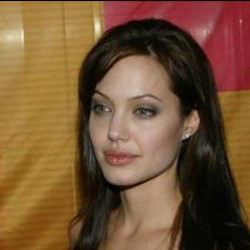

Resized Image


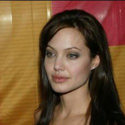

In [ ]:
from PIL import Image
from IPython.display import display
print("Original Image")
im = Image.open(fn)
display(im)
resized_im = im.resize((round(im.size[0]*0.5), round(im.size[1]*0.5)))
print("Resized Image")
display(resized_im)
resized_im.save('resized.jpg')


In [ ]:
pip install mtcnn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.3 MB 8.2 MB/s 


(160, 160, 3)


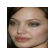

In [ ]:
from os import listdir
from os.path import isdir
from PIL import Image
from matplotlib import pyplot
from numpy import savez_compressed
from numpy import asarray
from mtcnn.mtcnn import MTCNN

# extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):
    # load image from file
    image = Image.open(filename)
    # convert to RGB, if needed
    image = image.convert('RGB')
    # convert to array
    pixels = asarray(image)
    # create the detector, using default weights
    detector = MTCNN()
    # detect faces in the image
    results = detector.detect_faces(pixels)
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = asarray(image)
    return face_array

#specify folder to plot
folder = 'drive/My Drive/data/test1//'
'''i = 1
# enumerate files
for filename in listdir(folder):
    # path
    path = folder + filename
    # get face'''
face = extract_face(fn)
print(face.shape)
# plot
pyplot.subplot(2, 7, 1)
pyplot.axis('off')
pyplot.imshow(face)
pyplot.show()

In [ ]:
# load images and extract faces for all images in a directory
def load_faces(directory):
    faces = list()
    # enumerate files
    for filename in listdir(directory):
        # path
        path = directory + filename
        # get face
        face = extract_face(path)
        # store
        faces.append(face)
    return faces

# load a dataset that contains one subdir for each class that in turn contains images
def load_dataset(directory):
    X, y = list(), list()
    # enumerate folders, on per class
    for subdir in listdir(directory):
        # path
        path = directory + subdir + '/'
        # skip any files that might be in the dir
        if not isdir(path):
            continue
        # load all faces in the subdirectory
        faces = load_faces(path)
        # create labels
        labels = [subdir for _ in range(len(faces))]
        # summarize progress
        print('>loaded %d examples for person: %s' % (len(faces), subdir))
        # store
        X.extend(faces)
        y.extend(labels)
    return asarray(X), asarray(y)
    for x in labels:
     print(x)
# load train dataset
dir_loc = 'drive/My Drive/lfw_dataset/train/'
trainX, trainy = load_dataset(dir_loc)
print(trainX.shape, trainy.shape)
# load test dataset
dir_loc = 'drive/My Drive/lfw_dataset/test/'
testX, testy = load_dataset(dir_loc)
print(testX.shape, testy.shape)
# save arrays to one file in compressed format
savez_compressed('init_face_array.npz', trainX, trainy,testX, testy)

>loaded 19 examples for person: Angelina_Jolie
>loaded 5 examples for person: Albert_Costa
>loaded 5 examples for person: JK_Rowling
>loaded 7 examples for person: John_Edwards
(36, 160, 160, 3) (36,)
>loaded 1 examples for person: John_Edwards
>loaded 1 examples for person: JK_Rowling
>loaded 1 examples for person: Angelina_Jolie
>loaded 1 examples for person: Albert_Costa
(4, 160, 160, 3) (4,)


In [ ]:
from numpy import load
data = load('init_face_array.npz')
lst = data.files
for item in lst:
    print(item)
    print(data[item])

arr_0
[[[[ 74  74  72]
   [ 75  75  74]
   [ 78  78  78]
   ...
   [ 26  23  30]
   [ 21  18  25]
   [ 18  15  22]]

  [[ 81  81  79]
   [ 81  81  80]
   [ 82  82  82]
   ...
   [ 24  21  28]
   [ 20  17  24]
   [ 18  15  22]]

  [[ 86  86  84]
   [ 86  86  85]
   [ 87  87  87]
   ...
   [ 25  22  29]
   [ 22  19  26]
   [ 21  18  25]]

  ...

  [[208 176 176]
   [225 196 196]
   [251 227 227]
   ...
   [239 243 246]
   [240 244 247]
   [241 244 247]]

  [[236 208 210]
   [245 220 223]
   [255 239 241]
   ...
   [239 243 246]
   [241 243 247]
   [242 243 247]]

  [[251 225 228]
   [252 233 235]
   [255 242 244]
   ...
   [238 242 245]
   [241 243 246]
   [242 243 247]]]


 [[[ 52  26  11]
   [ 48  23   8]
   [ 40  17   1]
   ...
   [ 18   2   2]
   [ 17   3   2]
   [ 17   3   2]]

  [[ 49  25  11]
   [ 45  22   7]
   [ 38  15   1]
   ...
   [ 18   3   1]
   [ 17   3   2]
   [ 17   3   2]]

  [[ 44  23   9]
   [ 42  20   7]
   [ 36  14   2]
   ...
   [ 18   3   0]
   [ 17   3   2]
   [ 

In [ ]:
# calculate a face embedding for each face in the dataset using facenet
from numpy import load
from numpy import expand_dims
#from numpy import asarray
#from numpy import savez_compressed
from keras.models import load_model

# get the face embedding for one face
def get_embedding(model, face_pixels):
    # scale pixel values
    face_pixels = face_pixels.astype('float32')
    # standardize pixel values across channels (global)
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean) / std
    # transform face into one sample
    samples = expand_dims(face_pixels, axis=0)
    # make prediction to get embedding
    yhat = model.predict(samples)
    return yhat[0]

# load the face dataset
data = load('init_face_array.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)
# load the facenet model
model = load_model('drive/My Drive/facenet_keras.h5')  #read readme file.
print('Loaded Model')
# convert each face in the train set to an embedding
newTrainX = list()
for face_pixels in trainX:
    embedding = get_embedding(model, face_pixels)
    newTrainX.append(embedding)
newTrainX= asarray(newTrainX)
print(newTrainX.shape)
# convert each face in the test set to an embedding
newTestX = list()
for face_pixels in testX:
      embedding = get_embedding(model, face_pixels)
      newTestX.append(embedding)
newTestX = asarray(newTestX)
print(newTestX.shape)
savez_compressed('faces-embeddings.npz', newTrainX, trainy,newTestX, testy)

Loaded:  (36, 160, 160, 3) (36,) (4, 160, 160, 3) (4,)
Loaded Model
(36, 128)
(4, 128)


In [ ]:
from numpy import load
data = load('faces-embeddings.npz')
lst = data.files
for item in lst:
    print(item)
    print(data[item])

arr_0
[[ 0.18593828 -0.6096498   1.4223558  ... -0.48080024 -0.5544468
   1.1744277 ]
 [-1.7624993  -0.480878    1.0475783  ...  0.05669852  0.43417042
   0.94511044]
 [-0.08887646 -0.20181751  0.55373245 ... -0.3662824  -0.9102363
   1.341816  ]
 ...
 [-1.1719993  -1.3335491  -0.10222653 ... -0.7725465   1.0857569
   1.5469103 ]
 [-0.55815196 -1.6053655  -0.54680353 ...  0.2566229   0.18016313
   0.7444572 ]
 [-1.2397676  -1.3691685   0.8808866  ... -0.15767938 -0.41505164
   1.2326164 ]]
arr_1
['Angelina_Jolie' 'Angelina_Jolie' 'Angelina_Jolie' 'Angelina_Jolie'
 'Angelina_Jolie' 'Angelina_Jolie' 'Angelina_Jolie' 'Angelina_Jolie'
 'Angelina_Jolie' 'Angelina_Jolie' 'Angelina_Jolie' 'Angelina_Jolie'
 'Angelina_Jolie' 'Angelina_Jolie' 'Angelina_Jolie' 'Angelina_Jolie'
 'Angelina_Jolie' 'Angelina_Jolie' 'Angelina_Jolie' 'Albert_Costa'
 'Albert_Costa' 'Albert_Costa' 'Albert_Costa' 'Albert_Costa' 'JK_Rowling'
 'JK_Rowling' 'JK_Rowling' 'JK_Rowling' 'JK_Rowling' 'John_Edwards'
 'John_Edwards

In [ ]:
from numpy import load
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
# load dataset
data = load('faces-embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Dataset: train=%d, test=%d' % (trainX.shape[0], testX.shape[0]))
# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)
# fit model
model = SVC(kernel='linear', probability=True)
model.fit(trainX, trainy)
# predict
yhat_train = model.predict(trainX)
yhat_test = model.predict(testX)
# score
score_train = accuracy_score(trainy, yhat_train)
score_test = accuracy_score(testy, yhat_test)
# summarize
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

Dataset: train=36, test=4
Accuracy: train=100.000, test=100.000


Predicted: Angelina_Jolie (90.647)
Expected: Angelina_Jolie


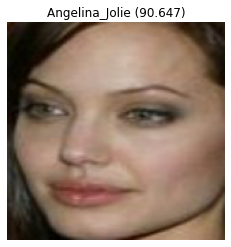

In [ ]:
# develop a classifier for the 5 Celebrity Faces Dataset
from random import choice
from numpy import load
from numpy import expand_dims
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from matplotlib import pyplot
# load faces
data = load('init_face_array.npz')
testX_faces = data['arr_2']
# load face embeddings
data = load('faces-embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)
# fit model
model = SVC(kernel='linear', probability=True)
model.fit(trainX, trainy)
# test model on a random example from the test dataset
selection=testX_faces[2]
sel=testX[2]
s=testy[2]
#selection = choice([i for i in range(testX.shape[0])])
#print(selection)
random_face_pixels = selection
random_face_emb = sel
random_face_class = s
random_face_name = out_encoder.inverse_transform([random_face_class])
# prediction for the face
samples = expand_dims(random_face_emb, axis=0)
yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)
# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Expected: %s' % random_face_name[0])
# plot for fun
pyplot.imshow(random_face_pixels)
title = '%s (%.3f)' % (predict_names[0], class_probability)
pyplot.title(title)
pyplot.axis('off')
pyplot.show()